In [99]:
import pandas as pd
import numpy as np

from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

In [10]:
data = pd.read_excel('HW_5.xlsx')


In [11]:
data.head(10)

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
5,2380,variant,0.0
6,2849,control,0.0
7,9168,control,0.0
8,6205,variant,0.0
9,7548,control,0.0


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [13]:
data.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [27]:
data.VARIANT_NAME.value_counts()

VARIANT_NAME
variant    5016
control    4984
Name: count, dtype: int64

### Избавимся от юзеров, которые попали в обе группы:

In [38]:
variants = data.groupby('USER_ID', as_index=False).agg({'VARIANT_NAME': pd.Series.nunique})


In [39]:
variants.head(10)

,USER_ID,VARIANT_NAME
0,2,1
1,3,2
2,4,1
3,5,1
4,6,1
5,9,1
6,10,2
7,11,1
8,12,1
9,13,1


In [40]:
more_than_one_types = variants.query('VARIANT_NAME > 1')

In [42]:
data_new = data[~data.USER_ID.isin(more_than_one_types.USER_ID)].sort_values('USER_ID')

In [48]:
data_new.shape

(6070, 3)

In [49]:
data.shape[0] - data_new.shape[0]

3930

#### 3930 наблюдений пришлось исключить в ходе подготовки данных, что составляет почти 40% от всех наблюдений. Данный факт ставит под сомнение корректность проведения эксперимента.

In [50]:
control = data_new.query('VARIANT_NAME == "control"')
test = data_new.query('VARIANT_NAME == "variant"')

In [51]:
len(control)

3026

In [52]:
len(test)

3044

### Проверим данные на нормальность:

In [62]:
st = stats.shapiro(data_new.REVENUE)
st


ShapiroResult(statistic=0.015946388244628906, pvalue=0.0)

Т.к. p-value меньше a (a = 0,05), делаем вывод что распределение не нормальное.

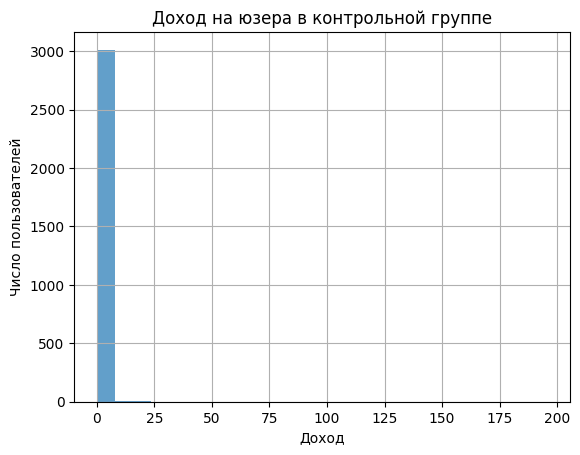

In [74]:
control.REVENUE.hist(bins=25, alpha=0.7, label='Control')
plt.title('Доход на юзера в контрольной группе')
plt.xlabel('Доход')
plt.ylabel('Число пользователей');

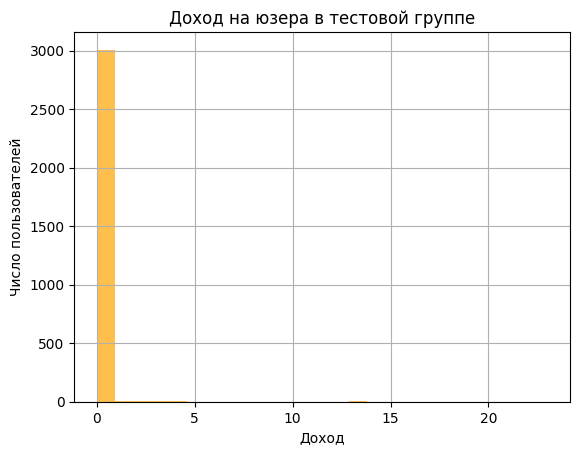

In [73]:
test.REVENUE.hist(bins=25, alpha=0.7, label='Test', color='orange')
plt.title('Доход на юзера в тестовой группе')
plt.xlabel('Доход')
plt.ylabel('Число пользователей');

### Т.к. распределение не нормальное, используем критерий Манна-Уитни:

In [77]:
mw_stats = stats.mannwhitneyu(x=control.REVENUE.values, y=test.REVENUE.values)
mw_stats

MannwhitneyuResult(statistic=4622832.0, pvalue=0.2444173738649208)

#### Т.к. p-value больше a (a = 0,05), делаем вывод что стат. значимых различий не обнаружено.

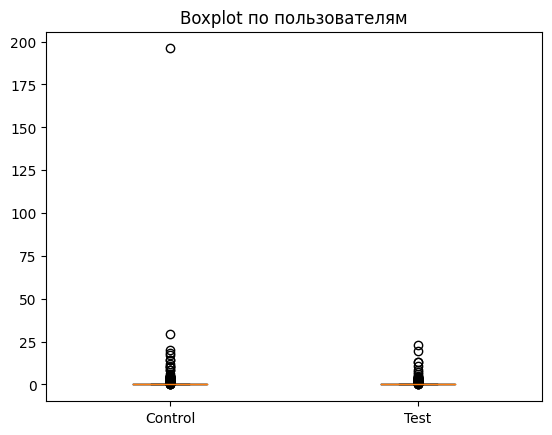

In [83]:
plt.boxplot([control.REVENUE,test.REVENUE],
            labels=['Control','Test'],
                    widths=0.3
                    )
plt.title('Boxplot по пользователям');


### Расчет мощности теста

In [ ]:
d = (M1 - M2) / S_pooled

In [86]:
C_mean = control.REVENUE.values.mean()

T_mean = test.REVENUE.values.mean()


C_std = control.REVENUE.values.std()

T_std = test.REVENUE.values.std()

In [85]:
n = len(control.REVENUE.values)


In [87]:
S = np.sqrt((T_std**2 + C_std**2) / 2)

# Если размер воборов разный формула следующая:
# S = np.sqrt((sd_t**2 / n_t) + (sd_c**2 / n_c))

In [88]:
ef = float((C_mean-T_mean) / S)

In [103]:
from statsmodels.stats.power import TTestIndPower

In [104]:
analysis = TTestIndPower()

result = analysis.solve_power(ef, power=None, nobs1=n, ratio=1.0, alpha = 0.05)

In [105]:
result

0.2893670730459213

### Вывод:
Тест не показал статистически значимой разницы между группами, однако имеются сомнения в корректности его проведения.
- 1ый фактор - большое количество ошибочных данных (почти 40%).
- 2ой фактор - малая мощность теста - около 30%.

Для объективного результата необходимо:
- исправить сплитование
- пересчитать необходимый объем выборки
- провести тест заново

После чего снова проанализировать корректные данные.